<a href="https://colab.research.google.com/github/ruus77/Portfolio/blob/main/Predicting_Vehicle_Prices_Using_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## *Vehicles prices predictions*
Sources used in this project:

- `Dataset` - [Vehicle dataset](https://www.kaggle.com/datasets/nehalbirla/vehicle-dataset-from-cardekho)

- All `metrics` and `formulas` are come from ISLP book - [An Introduction to Statistical Learning with Python](https://anthology-of-data.science/resources/james2023islp.pdf)


In [821]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
from zipfile import ZipFile
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

le = LabelEncoder()
import warnings
warnings.filterwarnings('ignore')


In [822]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ruus77","key":"90948a6bbdbedaa981a89d066115f5ef"}'}

###Data Loading and Preparation


In [823]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d nehalbirla/vehicle-dataset-from-cardekho


Dataset URL: https://www.kaggle.com/datasets/nehalbirla/vehicle-dataset-from-cardekho
License(s): DbCL-1.0
vehicle-dataset-from-cardekho.zip: Skipping, found more recently modified local copy (use --force to force download)


In [824]:
with ZipFile("/content/vehicle-dataset-from-cardekho.zip", "r") as zip_ref:
    zip_ref.extractall("/content/vehicle-dataset")


In [825]:
df = pd.read_csv("/content/vehicle-dataset/Car details v3.csv")
df.shape

(8128, 13)

In [826]:
df = df.copy()

In [827]:
df_cols = list(df.columns)
df_cols

['name',
 'year',
 'selling_price',
 'km_driven',
 'fuel',
 'seller_type',
 'transmission',
 'owner',
 'mileage',
 'engine',
 'max_power',
 'torque',
 'seats']

In [828]:
df.isna().sum()

,0
name,0
year,0
selling_price,0
km_driven,0
fuel,0
seller_type,0
transmission,0
owner,0
mileage,221
engine,221


In [829]:
for i in range(len(df_cols)):
  col_name = f"x{i}_{df_cols[i]}"
  if df_cols[i] == "selling_price":
    pass
  else: df_cols[i] = col_name

df.columns=df_cols
df.head()

,x0_name,x1_year,selling_price,x3_km_driven,x4_fuel,x5_seller_type,x6_transmission,x7_owner,x8_mileage,x9_engine,x10_max_power,x11_torque,x12_seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


##Data Cleaning


In [830]:
df.dtypes

,0
x0_name,object
x1_year,int64
selling_price,int64
x3_km_driven,int64
x4_fuel,object
x5_seller_type,object
x6_transmission,object
x7_owner,object
x8_mileage,object
x9_engine,object


In [831]:
empt_rows = []
for i in range(df.shape[0]):
    if df.iloc[i, :].isna().all():
        empt_rows.append(i)

empt_rows

[]

In [832]:
cols_to_fix = ["x8_mileage",	"x9_engine",	"x10_max_power"]
df[cols_to_fix].head()

,x8_mileage,x9_engine,x10_max_power
0,23.4 kmpl,1248 CC,74 bhp
1,21.14 kmpl,1498 CC,103.52 bhp
2,17.7 kmpl,1497 CC,78 bhp
3,23.0 kmpl,1396 CC,90 bhp
4,16.1 kmpl,1298 CC,88.2 bhp


In [833]:
df[cols_to_fix].isna().sum()

,0
x8_mileage,221
x9_engine,221
x10_max_power,215


In [834]:
df[cols_to_fix].dtypes

,0
x8_mileage,object
x9_engine,object
x10_max_power,object


In [835]:
for i in range(len(cols_to_fix)):
  df[cols_to_fix[i]] = df[cols_to_fix[i]].astype(str).str.split(" ").str[0]

"""for i in range(len(cols_to_fix)):
  df[cols_to_fix[i]] = pd.to_numeric(df[cols_to_fix[i]])
  ValueError: Unable to parse string "nan" at position 13
"""
df.iloc[13, :][8:]

,13
x8_mileage,nan
x9_engine,nan
x10_max_power,nan
x11_torque,NaN
x12_seats,NaN


In [836]:
df[cols_to_fix[0]] = df[cols_to_fix[0]].astype(float)
df[cols_to_fix[1]] = df[cols_to_fix[1]].astype(float)
df[cols_to_fix[2]] = pd.to_numeric(df[cols_to_fix[2]], errors="coerce")

In [837]:
df.rename(columns={
    "x8_mileage": "x8_mileage_kmpl",
    "x9_engine" : "x9_engine_cc",
    "x10_max_power" : "x10_max_power_bhp"
}, inplace=True)


In [838]:
from datetime import datetime
today = datetime.today()
df["today"] = today
df.today = df.today.astype(str).str.split("-").str[0]
df["x1_num_of_years"] = pd.to_numeric(df.today) - pd.to_numeric(df.x1_year)
df.drop(columns=["today", "x1_year"], inplace=True)


In [839]:
df.x1_num_of_years.head()

,x1_num_of_years
0,11
1,11
2,19
3,15
4,18


In [840]:
df["x4_fuel"].value_counts()


,count
x4_fuel,
Diesel,4402
Petrol,3631
CNG,57
LPG,38


In [841]:
df.x5_seller_type.value_counts()

,count
x5_seller_type,
Individual,6766
Dealer,1126
Trustmark Dealer,236


In [842]:
df.x6_transmission.value_counts()

,count
x6_transmission,
Manual,7078
Automatic,1050


In [843]:
df.x7_owner.value_counts()

,count
x7_owner,
First Owner,5289
Second Owner,2105
Third Owner,555
Fourth & Above Owner,174
Test Drive Car,5


In [844]:
mappings = {
    "x4_fuel": {
        "Diesel": 1,
        "Petrol": 2,
        "CNG": 3,
        "LPG": 4
    },
    "x5_seller_type": {
        "Individual": 1,
        "Dealer": 2,
        "Trustmark Dealer": 3
    },
    "x6_transmission": {
        "Manual": 1,
        "Automatic": 2
    },
    "x7_owner" : {
      "First Owner" : 1,
      "Second Owner" : 2,
      "Third Owner" : 3,
      "Fourth & Above Owner" : 4,
      "Test Drive Car" : 5

    }
}
df.replace(mappings, inplace=True)


In [845]:
df.head()

,x0_name,selling_price,x3_km_driven,x4_fuel,x5_seller_type,x6_transmission,x7_owner,x8_mileage_kmpl,x9_engine_cc,x10_max_power_bhp,x11_torque,x12_seats,x1_num_of_years
0,Maruti Swift Dzire VDI,450000,145500,1,1,1,1,23.40,1248.0,74.00,190Nm@ 2000rpm,5.0,11
1,Skoda Rapid 1.5 TDI Ambition,370000,120000,1,1,1,2,21.14,1498.0,103.52,250Nm@ 1500-2500rpm,5.0,11
2,Honda City 2017-2020 EXi,158000,140000,2,1,1,3,17.70,1497.0,78.00,"12.7@ 2,700(kgm@ rpm)",5.0,19
3,Hyundai i20 Sportz Diesel,225000,127000,1,1,1,1,23.00,1396.0,90.00,22.4 kgm at 1750-2750rpm,5.0,15
4,Maruti Swift VXI BSIII,130000,120000,2,1,1,1,16.10,1298.0,88.20,"11.5@ 4,500(kgm@ rpm)",5.0,18


In [846]:
df["car_brand"] = df.x0_name.str.split(" ").str[0]
df["car_type"] = df.x0_name.str.split(" ").str[1]
df.car_brand = le.fit_transform(df.car_brand)
df.car_type = le.fit_transform(df.car_type)
df.drop(columns = ["x11_torque"], inplace=True)
df.head()

,x0_name,selling_price,x3_km_driven,x4_fuel,x5_seller_type,x6_transmission,x7_owner,x8_mileage_kmpl,x9_engine_cc,x10_max_power_bhp,x12_seats,x1_num_of_years,car_brand,car_type
0,Maruti Swift Dzire VDI,450000,145500,1,1,1,1,23.40,1248.0,74.00,5.0,11,20,161
1,Skoda Rapid 1.5 TDI Ambition,370000,120000,1,1,1,2,21.14,1498.0,103.52,5.0,11,27,135
2,Honda City 2017-2020 EXi,158000,140000,2,1,1,3,17.70,1497.0,78.00,5.0,19,10,36
3,Hyundai i20 Sportz Diesel,225000,127000,1,1,1,1,23.00,1396.0,90.00,5.0,15,11,206
4,Maruti Swift VXI BSIII,130000,120000,2,1,1,1,16.10,1298.0,88.20,5.0,18,20,161


In [847]:
df.columns

Index(['x0_name', 'selling_price', 'x3_km_driven', 'x4_fuel', 'x5_seller_type',
       'x6_transmission', 'x7_owner', 'x8_mileage_kmpl', 'x9_engine_cc',
       'x10_max_power_bhp', 'x12_seats', 'x1_num_of_years', 'car_brand',
       'car_type'],
      dtype='object')

In [848]:
col_name = list(df.columns)
col_name = ['name',
 'y_selling_price',
 'x1_km_driven',
 'x2_fuel',
 'x3_seller_type',
 'x4_transmission',
 'x5_owner',
 'x6_mileage_kmpl',
 'x7_engine_cc',
 'x8_max_power_bhp',
 'x9_seats',
 'x10_num_of_years',
 'x11_car_brand',
 'x12_car_type']
df.columns = col_name
df.head()

,name,y_selling_price,x1_km_driven,x2_fuel,x3_seller_type,x4_transmission,x5_owner,x6_mileage_kmpl,x7_engine_cc,x8_max_power_bhp,x9_seats,x10_num_of_years,x11_car_brand,x12_car_type
0,Maruti Swift Dzire VDI,450000,145500,1,1,1,1,23.40,1248.0,74.00,5.0,11,20,161
1,Skoda Rapid 1.5 TDI Ambition,370000,120000,1,1,1,2,21.14,1498.0,103.52,5.0,11,27,135
2,Honda City 2017-2020 EXi,158000,140000,2,1,1,3,17.70,1497.0,78.00,5.0,19,10,36
3,Hyundai i20 Sportz Diesel,225000,127000,1,1,1,1,23.00,1396.0,90.00,5.0,15,11,206
4,Maruti Swift VXI BSIII,130000,120000,2,1,1,1,16.10,1298.0,88.20,5.0,18,20,161


In [849]:
df_na = df.loc[:, df.isna().any()==True]
df_na.head()

,x6_mileage_kmpl,x7_engine_cc,x8_max_power_bhp,x9_seats
0,23.40,1248.0,74.00,5.0
1,21.14,1498.0,103.52,5.0
2,17.70,1497.0,78.00,5.0
3,23.00,1396.0,90.00,5.0
4,16.10,1298.0,88.20,5.0


In [850]:
df_na.isna().sum()

,0
x6_mileage_kmpl,221
x7_engine_cc,221
x8_max_power_bhp,216
x9_seats,221


In [851]:
na_cols = list(df_na.columns)

In [852]:
median_values = df[na_cols].median()
df = df.fillna(median_values)
df.isna().sum()

,0
name,0
y_selling_price,0
x1_km_driven,0
x2_fuel,0
x3_seller_type,0
x4_transmission,0
x5_owner,0
x6_mileage_kmpl,0
x7_engine_cc,0
x8_max_power_bhp,0


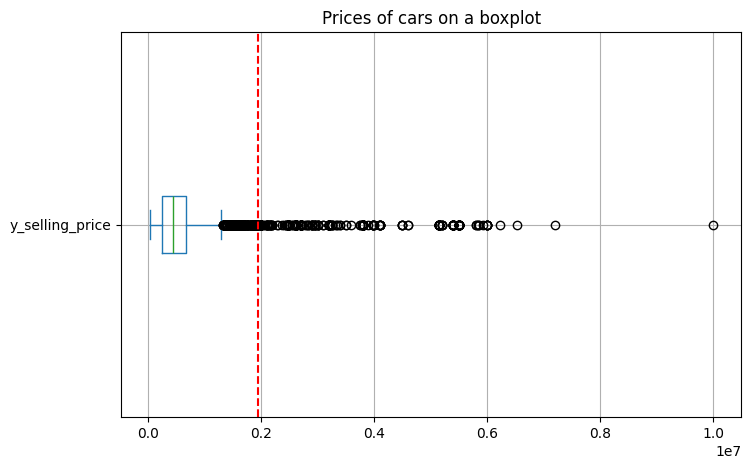

In [853]:
df.y_selling_price.plot.box(grid=True, figsize=(8, 5), vert=False, title="Prices of cars on a boxplot");
plt.axvline(df.y_selling_price.quantile(.95), c="r", linestyle="--");

In [854]:
df.loc[df.y_selling_price > df.y_selling_price.quantile(.95)].shape[0]

403

In [855]:
df.y_selling_price = np.where(
  df.y_selling_price > df.y_selling_price.quantile(.95), np.nan, df.y_selling_price
)

In [856]:
df = df.dropna()

##Exploratory Data Analysis

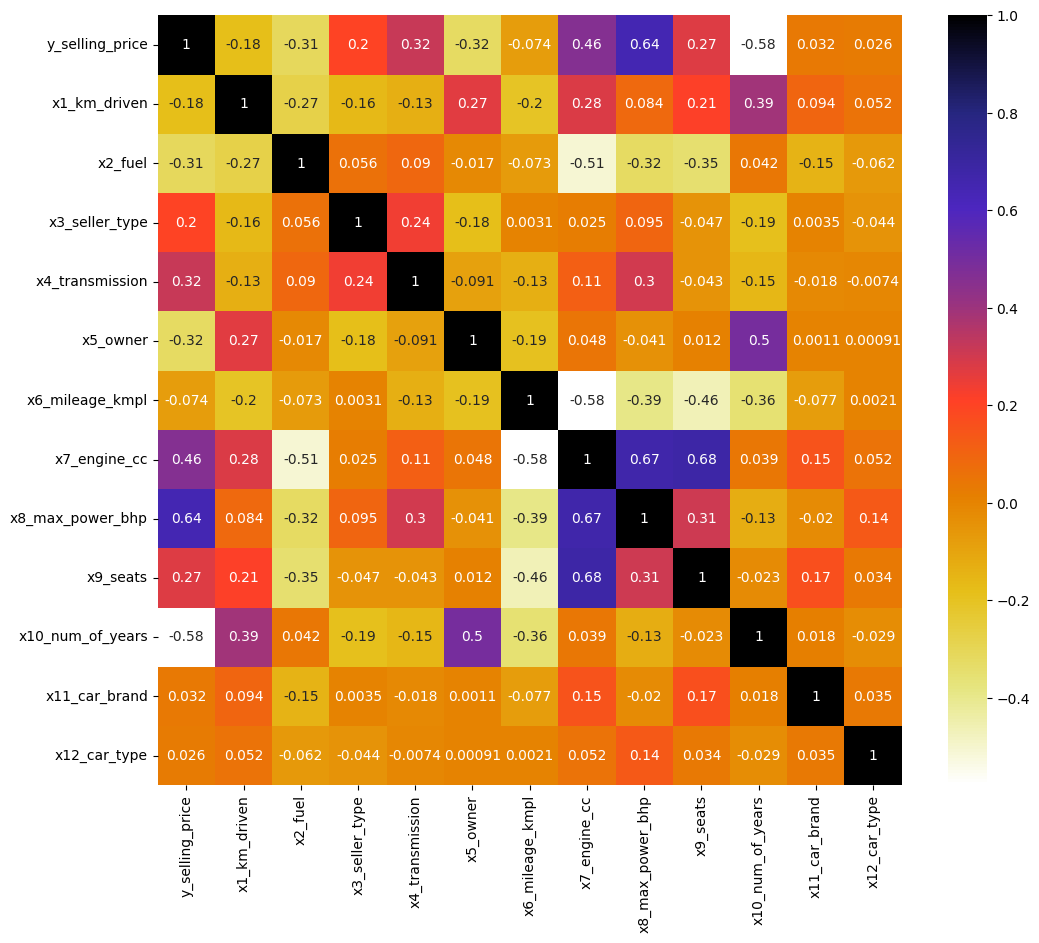

In [857]:
corr=df.drop(columns=["name"]).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    cmap='CMRmap_r',
    annot=True,

);

In [858]:
corr.y_selling_price.apply(np.abs).sort_values(ascending=False)

,y_selling_price
y_selling_price,1.000000
x8_max_power_bhp,0.644819
x10_num_of_years,0.577942
x7_engine_cc,0.458991
x5_owner,0.321398
x4_transmission,0.315929
x2_fuel,0.310846
x9_seats,0.272109
x3_seller_type,0.199445
x1_km_driven,0.182058


## Data Preparation for Modeling
Correlation between dependent variable $y$ and $X_{6}$, $X_{11}$, $X_{12}$ is insignificant so these predictors are excluded from further analysis.

In [859]:
x_cols = df.columns.drop(["name", "y_selling_price", "x11_car_brand", 'x12_car_type', "x6_mileage_kmpl"])
x_cols = list(x_cols)
x_cols

['x1_km_driven',
 'x2_fuel',
 'x3_seller_type',
 'x4_transmission',
 'x5_owner',
 'x7_engine_cc',
 'x8_max_power_bhp',
 'x9_seats',
 'x10_num_of_years']

In [860]:
X = df[x_cols]
y = df['y_selling_price']


In [861]:
int(0.3*(X.shape[0]))

2317

## data Standardization
$$Z_{i} = \frac{x_i - μ}{σ}$$ $i \in {1, 2, ...,  n}$


where $n$ is a number of rows in $X$


In [862]:
for i in range(X.shape[1]):
  col = x_cols[i]
  X[col] = (X[col] - X[col].mean()) / X[col].std()
X

,x1_km_driven,x2_fuel,x3_seller_type,x4_transmission,x5_owner,x7_engine_cc,x8_max_power_bhp,x9_seats,x10_num_of_years
0,1.291087,-0.899800,-0.376529,-0.305624,-0.662253,-0.350963,-0.443764,-0.433522,-0.097368
1,0.843142,-0.899800,-0.376529,-0.305624,0.711513,0.181374,0.619694,-0.433522,-0.097368
2,1.194471,0.943955,-0.376529,-0.305624,2.085278,0.179245,-0.299664,-0.433522,1.883970
3,0.966108,-0.899800,-0.376529,-0.305624,-0.662253,-0.035819,0.132636,-0.433522,0.893301
4,0.843142,0.943955,-0.376529,-0.305624,-0.662253,-0.244496,0.067791,-0.433522,1.636303
...,...,...,...,...,...,...,...,...,...
8123,0.667478,0.943955,-0.376529,-0.305624,-0.662253,-0.459560,-0.124942,-0.433522,0.150300
8124,0.825576,-0.899800,-0.376529,-0.305624,3.459044,0.170728,0.853136,-0.433522,1.636303
8125,0.843142,-0.899800,-0.376529,-0.305624,-0.662253,-0.350963,-0.447366,-0.433522,1.140968
8126,-0.825669,-0.899800,-0.376529,-0.305624,-0.662253,-0.035819,-0.587864,-0.433522,0.150300


In [863]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=int(0.3*(X.shape[0])), random_state=777)

##Building and Evaluating the Linear Regression Model
Linear Regression model formula:
$$ Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_p X_p + \epsilon$$
where:
- $p$  -  a number of columns in $X$
- $\beta_p$ -  a regression coeficient
- $\beta_0$ -  an intercept term
- $\epsilon$ -  a random error term

In [864]:
lr = LinearRegression()
lr.fit(X_train, y_train);


In [865]:
lr.coef_

array([ -20022.89379553,  -35164.77178437,    9831.75190597,
         27826.94786316,  -17248.87452945,   35592.95115168,
        137123.47415804,   10634.87099806, -141188.85122941])

In [866]:
lr.rank_, X.shape[1]
# all columns are independent

(9, 9)

In [867]:
lr.intercept_

np.float64(482558.30971118266)

In [868]:
y_pred = lr.predict(X_test)

## Model Evaluation

###to evaluate model's performance we use:
#### $R^2$ - a measure of the fit (variability) of the model

Value of $R^2$ always falls between 0 and 1 ($R^2 \in [0, 1]$),

where $R^2$ close to 1 inform that large proportion of the variability is explained by the regression

$$ R^2 = 1 - \frac{RSS}{TSS}$$
where:

* $RSS$ = $\sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^{2}$,    $\hat{y}$ - `y_pred`

* $TSS$ = $\sum_{i=1}^{n} (y_{i} - \overline{y})^{2}$,
$\overline{y} $ - `y_mean`


#### $F$-Test- assesses the overall significance of a regression model. It checks if at least one predictor is useful in predicting the response.

* **Null Hypothesis ($H_0$)**: All regression coefficients are equal to zero ($\beta_1 = \beta_2 = \dots = \beta_p = 0$). The model has no predictive power.
* **Alternative Hypothesis ($H_1$)**: At least one coefficient is non-zero. The model is useful.

$$F = \frac{(TSS - RSS) / p}{RSS / (n - p - 1)}$$

* `p`: number of columns
* `n`: number of raws

A large $F$-statistic allow us to reject $H_0$, which means the model is statistically significant.


#### Root Mean Squared Error (RMSE) -  measures the square root of the average of the squared differences between the actual and predicted values. It represents the standard deviation of the residuals (prediction errors).

$$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n}(y_{i}-\hat{y}_{i})^{2}} =
\sqrt{\frac{RSS}{n}}$$

* A lower RMSE value indicates a better model fit. An RMSE of 0 represents a perfect fit.
* Because the errors are squared before being averaged, RMSE gives higher weight to larger errors, making it sensitive to outliers.


In [869]:
def model_eval(y_pred:np.array, y_test:np.array, X_test:np.array):
    residuals = y_test - y_pred
    rss = (residuals**2).sum()
    rse = np.sqrt(rss/(X_test.shape[0] - X_test.shape[1]-1))
    tss = ((y_test - y_test.mean())**2).sum()

    R_squared = 1 - rss/tss

    F_test = ((tss - rss) / X_test.shape[1]) / (rss / (X_test.shape[0] - X_test.shape[1] - 1))

    rmse = np.sqrt(((y_test - y_pred)**2).sum()/X_test.shape[0])

    return pd.DataFrame({"R_squared": [R_squared], "F_test": [F_test] , "rmse" : [rmse]})

In [870]:
results_1 = model_eval(y_pred, y_test, X_test)
results_1

,R_squared,F_test,rmse
0,0.702258,604.590083,173534.159632


In [871]:
y_plot = y_test.reset_index()
y_plot = y_plot.y_selling_price
y_plot = pd.Series(y_plot)
y_plot.shape, y_pred.shape

((2317,), (2317,))

In [872]:
y_eval = pd.concat([y_plot, pd.Series(y_pred)], axis="columns")
y_eval.columns = ["y_test", "y_pred"]
y_eval.head()

,y_test,y_pred
0,50000.0,66013.688793
1,700000.0,620952.611603
2,140000.0,385427.267227
3,120000.0,174417.177565
4,411000.0,362873.521188


## Visualizing Model Results

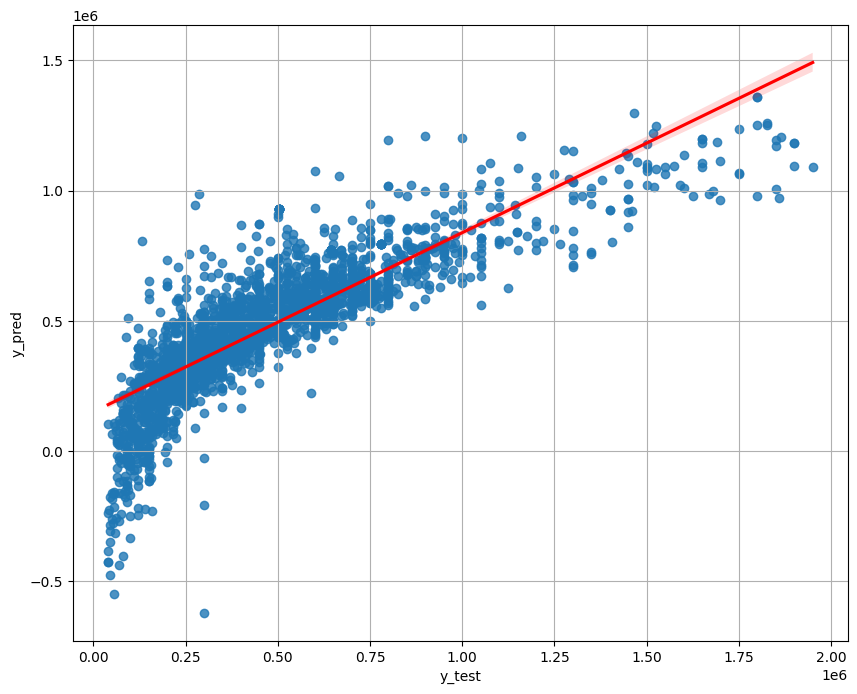

In [873]:
plt.figure(figsize=(10, 8))
plt.grid(True)
sns.regplot(
    x='y_test',
    y='y_pred',
    data=y_eval,
    line_kws={'color': 'red'}
    );

## Logarithmic Transformation
The data suggests a logarithmic relationship. Let's check how the model behaves after applying a log transformation to the dependent variable $y$.

In [874]:
y_log = np.log1p(y)
# np.log1p = np.log(x+1)

In [875]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=int(0.3*(X.shape[0])), random_state=777)


In [876]:
lr = LinearRegression()
lr.fit(X_train, y_train);


In [877]:
y_pred =lr.predict(X_test)
y_pred = np.expm1(y_pred)
y_test = y.loc[y_test.index]

In [878]:
residuals = y_test - y_pred
rss = (residuals**2).sum()
rss

mse = rss/X_test.shape[0]
mse

rse = np.sqrt(rss/(X_test.shape[0] - X_test.shape[1]-1))
rse

tss = ((y_test - y_test.mean())**2).sum()
R_squared = 1 - rss/tss
R_squared

np.float64(0.7997609215386887)

In [879]:
F_test = ((tss - rss) / X_test.shape[1]) / (rss / (X_test.shape[0] - X_test.shape[1] - 1))
F_test

np.float64(1023.8030681276842)

In [880]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

np.float64(142311.21078857346)

In [881]:
results_2 = pd.DataFrame({"R_squared": [R_squared], "F_test": [F_test] , "rmse" : [rmse]})
results_2

,R_squared,F_test,rmse
0,0.799761,1023.803068,142311.210789


In [882]:
y_plot = y_test.reset_index()
y_plot = y_plot.y_selling_price
y_plot = pd.Series(y_plot)
y_eval = pd.concat([y_plot, pd.Series(y_pred)], axis="columns")
y_eval.columns = ["y_test", "y_pred"]
y_eval.head()


,y_test,y_pred
0,50000.0,111529.974455
1,700000.0,581397.226307
2,140000.0,323311.859197
3,120000.0,169381.810327
4,411000.0,308566.464347


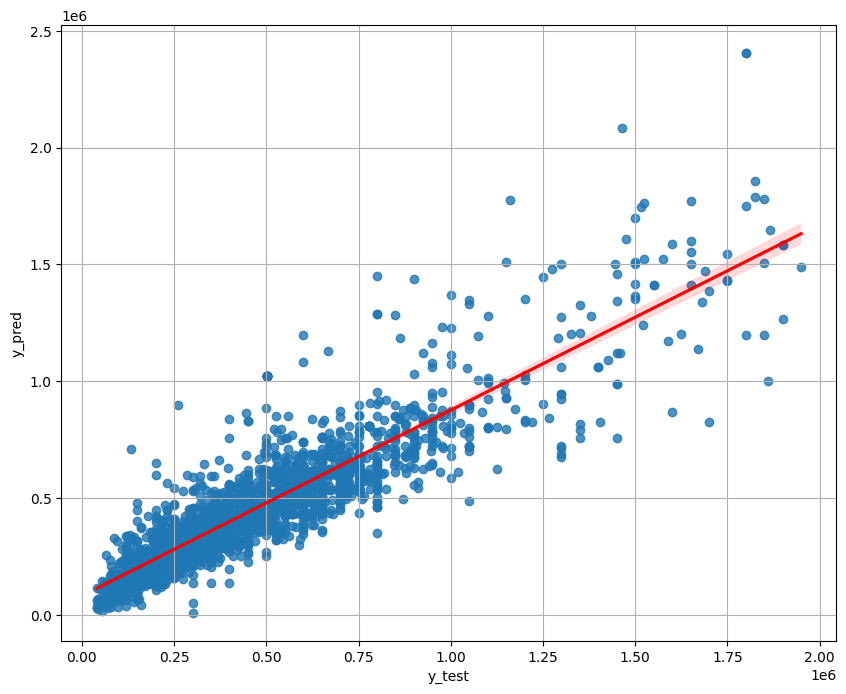

In [883]:
plt.figure(figsize=(10, 8))
plt.grid(True)
sns.regplot(
    x='y_test',
    y='y_pred',
    data=y_eval,
    line_kws={'color': 'red'}
    );

In [884]:
results = pd.concat([results_1.T, results_2.T], axis=1)
results.columns = ["1_approach", "2_approach"]
results

,1_approach,2_approach
R_squared,0.702258,0.799761
F_test,604.590083,1023.803068
rmse,173534.159632,142311.210789


### Summary
The log transformation `2_approach` significantly improved the model's performance. The **R-squared** value increased from 0.70 to almost 0.80, and the **RMSE** decreased from 173534 to 142311. These changes, along with a higher **F-test**, indicate the transformed model provides a better fit and more accurate predictions.